In [1]:
import numpy as np
import iris
from scipy.stats import expon
import matplotlib.pyplot as plt
import glob

In [2]:
def identify_rainy_periods(rainfall_data, threshold):
    rainy_periods = []  # Initialize list to store rainy periods
    is_raining = False  # Flag to track if it's raining
    start_time = None   # Variable to store start time of rainy period

    # Iterate through each timestep's rainfall value
    for time, precipitation in enumerate(rainfall_data):
        print(precipitation)

        # If precipitation exceeds threshold....
        if precipitation >= threshold:
            print("precip over threshold")
            # If it's not already raining and precipitation exceeds threshold, start a new rainy period
            if not is_raining:
                start_time = time  # Record start time of rainy period
                is_raining = True  # Set flag to indicate it's raining

        # If precip doesn't exceed threshold, and it has been raining before
        elif is_raining == True:
            print("Precip not over threshold, was raining before, end this rainy period")
            # End current rainy period and record its start and end times
            rainy_periods.append((start_time, time - 1))
            is_raining = False  # Reset flag to indicate it's not raining

        # If precip doesn't exceed threshold, and it hasn't been raining before
        else:
            print("Precip not over threshold, and it wasn't raining before")

    # Check if last period was rainy
    if is_raining == True:
        # If raining at the end of the data, consider it as the end time of the last rainy period
        rainy_periods.append((start_time, len(rainfall_data) - 1))
    
    return rainy_periods

def estimate_tb0(rainfall_data, threshold, max_tb0_iterations=100, tolerance=0.01):
    # Identify rainy and dry periods
    rainy_periods = identify_rainy_periods(rainfall_data, threshold)
    
    # Initialize parameters
    tb0 = None
    iteration = 0
    
    # Iterate to estimate tb0
    while iteration < max_tb0_iterations:
        # Calculate inter-event times assuming tb0
        inter_event_times = calculate_inter_event_times(rainy_periods, tb0)
        
        # Test if inter-event times follow exponential distribution
        if is_exponential_distribution(inter_event_times, tolerance):
            return tb0
        
        # Estimate new tb0 based on the mean inter-event time
        tb0 = np.mean(inter_event_times)
        iteration += 1
    
    # If max iterations reached without convergence, return None
    return None


def calculate_inter_event_times(rainy_periods):
    """
    Calculate inter-event times between rainy periods.

    Parameters:
    - rainy_periods: List of tuples representing start and end times of rainy periods.

    Returns:
    - inter_event_times: List of inter-event times.
    """
    inter_event_times = []
    end_time_prev = 0

    # Calculate inter-event times based on the start and end times of rainy periods
    # time periods are one hour
    for start_time, end_time in rainy_periods:
        # Find the time between the start time of a rainy event, and the end time of the previous event
        inter_event_time = start_time - end_time_prev
        # Add it to a list of inter_event_times
        inter_event_times.append(inter_event_time)
        # Update the end_time_prev parameter to be the end time of this event
        end_time_prev = end_time

    return inter_event_times

def is_exponential_distribution(data, tolerance):
    # Fit data to exponential distribution
    _, p_value = expon.fit(data)
    print( p_value > tolerance)
    # Test if p-value of fit is within tolerance
    return p_value > tolerance

# Function to plot inter-event times
def plot_inter_event_times(inter_event_times):
    """
    Plot the distribution of inter-event times.

    Parameters:
    - inter_event_times: List or array containing inter-event times.
    """
    # Plot histogram of inter-event times
    plt.figure(figsize=(8, 6))
    plt.hist(inter_event_times, bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title('Distribution of Inter-Event Times')
    plt.xlabel('Inter-Event Time')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()
    
def identify_rainy_periods(rainfall_data, is_raining_threshold,dry_spell_threshold):
    rainy_periods = []  # Initialize list to store rainy periods
    within_rainfall_period = False  # Flag to track if it's raining
    it_rained_last_time = False  # Flag to track if it's raining
    start_time = None   # Variable to store start time of rainy period
    dry_spell_count = 0  # Counter for consecutive timesteps without rain
    
    # Iterate through each timestep's rainfall value
    for time, precipitation in enumerate(rainfall_data):
        # print(time, precipitation)

        # If precipitation exceeds threshold....
        if precipitation >= is_raining_threshold:
            # print("It's raining")
            # If it's not already raining and precipitation exceeds threshold, start a new rainy period
            if within_rainfall_period == False:
                start_time = time  # Record start time of rainy period
                within_rainfall_period = True  # Set flag to indicate it's raining
                it_rained_last_time = True
                dry_spell_count = 0  # Reset dry spell counter
            if within_rainfall_period == True and it_rained_last_time == False:
                dry_spell_count = 0 
                
        # If it isn't raining now, but we're currently within a rainfall event
        elif within_rainfall_period == True:
            
            #print("its not raining, but we are still within a rainfall event")
            it_rained_last_time = False
#             if it_rained_last_time == True and dry_spell_count == 1:
#                 dry_spell_count = 0
            
            # Increment dry spell counter
            # But only if 
            dry_spell_count += 1
            # print(f"the dry spell counter is on {dry_spell_count}")
            
            # Check if dry spell threshold reached
            if dry_spell_count >= dry_spell_threshold:
                # print("we can no longer consider this to be part of the rainy period")
                # End current rainy period and record its start and end times
                # print(start_time, time - 1)
                rainy_periods.append((start_time, time - 1))
                within_rainfall_period = False  # Reset flag to indicate it's not raining
            
        # If it isn't raining now, and we're not currently within a rainfall event
        else:
            # print ("its not raining now and we aren't within a rainfall event ")
            pass  # No action needed, continue iterating

    # Check if last period was rainy
    if within_rainfall_period == True:
        # If raining at the end of the data, consider it as the end time of the last rainy period
        rainy_periods.append((start_time, len(rainfall_data) - 1))
    
    return rainy_periods

### Get one year of UKCP18 data as a timeseries 

In [5]:
yr = 1990
em = '01'
datadir = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_hourly/2.2km_regridded_12km/1980_2001/{em}/'
file_name = datadir + f"{yr}_maskedcube.nc"
this_yr = iris.load(file_name)[0]

filenames =[]
for yr in range(1981,2001):
    file_name = datadir + f"{yr}_maskedcube.nc"
    filenames.append(file_name)
monthly_cubes_list = iris.load(filenames)
model_cube = monthly_cubes_list.concatenate_cube()   

rainfall_data = model_cube[:,50,42].data
len(rainfall_data)

42480

In [1]:
rainfall_data

NameError: name 'rainfall_data' is not defined

### Get one year of radar data

In [4]:
# year = 2006

# # Create directory to store outputs in and get general filename to load files from
# general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/NIMROD/5mins/OriginalFormat_1km/2006/*'

# # GET LIST OF ALL FILENAMES FOR THIS YEAR
# filenames =[]
# # Find all files in directory which start with this string
# for filename in glob.glob(general_filename):
#     # print(filename)
#     filenames.append(filename)
# print(f"loading {len(filenames)} filenames")
# sorted_list = sorted(filenames)

# # LOAD THE DATA
# in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)
# monthly_cubes_list = iris.load(sorted_list, in_jja)

# ##################################################################
# # CLEAN AND JOIN THE DATA
# ##################################################################
# # Get rid of any files which don't have the time dimension
# is_to_delete = []
# for i in range(0,len(monthly_cubes_list) ):
#     if len(monthly_cubes_list[i].shape) <3:
#         is_to_delete.append(i)
# for i in is_to_delete:
#     print(f"deleting cube {i} as it only had one dimension")
#     del monthly_cubes_list[i] 

# for i in range(0, len(monthly_cubes_list)):
#     try:
#         monthly_cubes_list[i].coord('forecast_period')
#         monthly_cubes_list[i].remove_coord('forecast_period')
#     except:
#         pass
#     try:
#         monthly_cubes_list[i].coord('forecast_reference_time')
#         monthly_cubes_list[i].remove_coord('forecast_reference_time')
#     except:
#         pass           
#     try:
#         monthly_cubes_list[i].coord('hour')
#         monthly_cubes_list[i].remove_coord('hour')
#     except:
#         pass   

# # Try to make attributes the same
# iris.util.equalise_attributes(monthly_cubes_list)   

# # CONVERT TO FLOAT64
# for i in range(0, len(monthly_cubes_list)):
#     monthly_cubes_list[i].data = monthly_cubes_list[i].data.astype('float64')

# model_cube = monthly_cubes_list.concatenate_cube()

### Threshold

In [9]:
its_raining_thresh = 0.1

### Detect Rainy Periods: 
Iterate through the rainfall data, identifying consecutive time intervals (e.g., hours, days) where the precipitation exceeds the threshold.  
Record the start and end times of each rainy period.

In [143]:
# for i in range(len(this_yr.coord('projection_y_coordinate').points)):
#     for j in range(len(this_yr.coord('projection_x_coordinate').points)):
#         this_cell = this_yr[:,i,j]
#         if np.nanmax(this_cell.data)>1:
#             print(i, j)

In [11]:
np.array(inter_event_times)

array([  5,   5, 100, ...,   2, 280,  99])

In [14]:
import numpy as np
from scipy.stats import expon, kstest
import matplotlib.pyplot as plt

def another_exponential_test(inter_event_times):
    # inter_event_times = np.diff(np.where(np.diff(np.concatenate(([True], dry_spell_durations > 0, [True]))) == 1)[0])
    inter_event_times = np.array(inter_event_times)
    # Fit exponential distribution to inter-event times
    params = expon.fit(inter_event_times)
    lambda_fit = params[1]  # Estimated lambda parameter of the exponential distribution

    # Perform Kolmogorov-Smirnov test
    ks_statistic, p_value = kstest(inter_event_times, 'expon', args=params)

    # Generate x values for the fitted exponential distribution
    x_values = np.linspace(0, inter_event_times.max(), 100)
    # Calculate corresponding y values using the fitted distribution parameters
    y_values = expon.pdf(x_values, *params)

    # Plot histogram of inter-event times
    plt.hist(inter_event_times, bins=10, density=True, alpha=0.7, color='blue', label='Inter-event times histogram')

    # Plot fitted exponential distribution
    plt.plot(x_values, y_values, color='red', label='Fitted exponential distribution')

    plt.xlabel('Inter-event Time (days)')
    plt.ylabel('Probability Density')
    plt.title('Inter-event Time Distribution of Dry Spells')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Estimated lambda parameter of the exponential distribution:", lambda_fit)
    print("Kolmogorov-Smirnov test statistic:", ks_statistic)
    print("P-value:", p_value)


## Estimate tbo

### Find the times between rain events

In [6]:
rainy_periods = identify_rainy_periods(rainfall_data, is_raining_threshold = 0.01, dry_spell_threshold= 3)

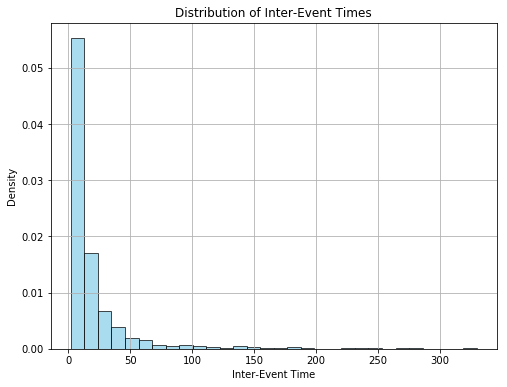

In [7]:
inter_event_times = calculate_inter_event_times(rainy_periods)
plot_inter_event_times(inter_event_times)

### Test different tbo values and check whether they resul in exponentially distributed inter-event times

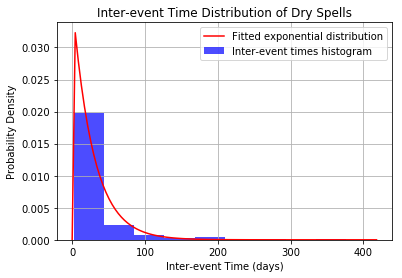

Estimated lambda parameter of the exponential distribution: 28.642696629213482
Kolmogorov-Smirnov test statistic: 0.17629511579858004
P-value: 1.1498995224231041e-24


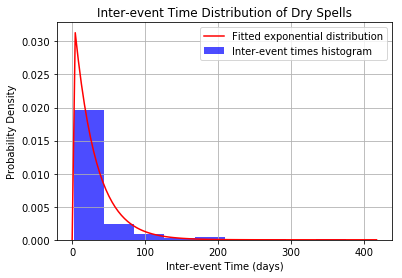

Estimated lambda parameter of the exponential distribution: 29.640625
Kolmogorov-Smirnov test statistic: 0.17781692111081626
P-value: 1.746063994587913e-23


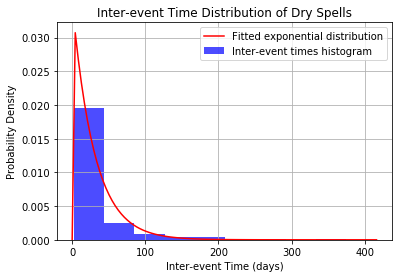

Estimated lambda parameter of the exponential distribution: 30.257287705956905
Kolmogorov-Smirnov test statistic: 0.18199197429648978
P-value: 2.431061868410757e-23


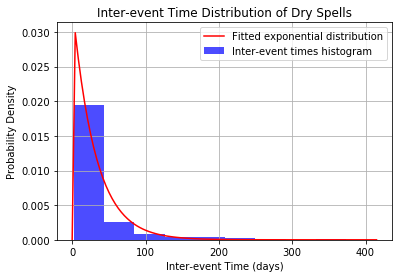

Estimated lambda parameter of the exponential distribution: 31.17520215633423
Kolmogorov-Smirnov test statistic: 0.18404041296912244
P-value: 1.8070115489376576e-22


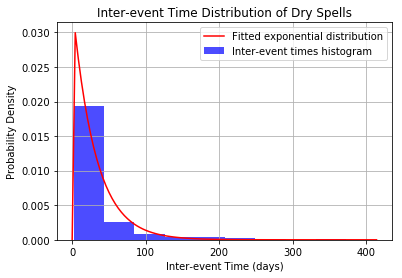

Estimated lambda parameter of the exponential distribution: 31.12916666666667
Kolmogorov-Smirnov test statistic: 0.19056033790661064
P-value: 2.2686556940152944e-23


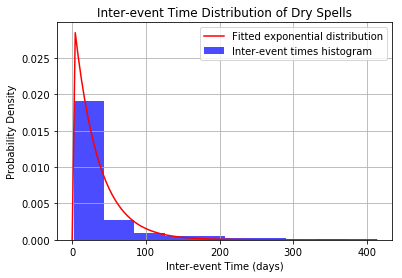

Estimated lambda parameter of the exponential distribution: 32.858006042296076
Kolmogorov-Smirnov test statistic: 0.18781006426177782
P-value: 6.441661245967445e-21


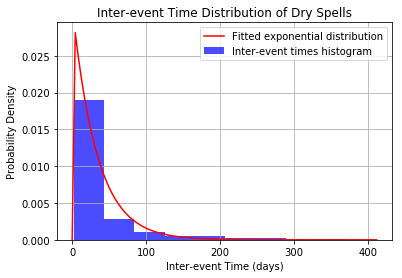

Estimated lambda parameter of the exponential distribution: 33.31072555205047
Kolmogorov-Smirnov test statistic: 0.19107327124466544
P-value: 9.570506111723656e-21


In [18]:
for dry_spell_threshold in range(8,15):
    rainy_periods = identify_rainy_periods(rainfall_data,is_raining_threshold = 0.1, dry_spell_threshold = dry_spell_threshold)
    inter_event_times = calculate_inter_event_times(rainy_periods)
    # is_exponential_distribution1(inter_event_times, 0.05)
    #is_exponential_distribution2(inter_event_times, 0.01)
    another_exponential_test(inter_event_times)


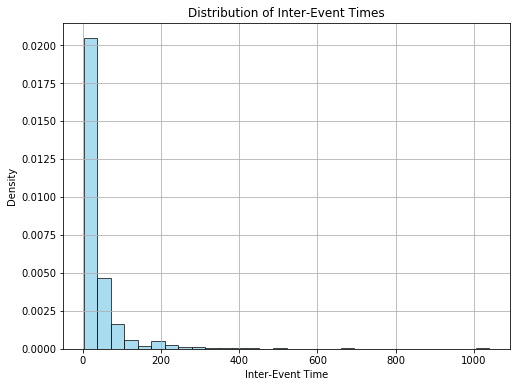

In [15]:
plot_inter_event_times(inter_event_times)

In [16]:
from scipy.stats import expon, kstest

def is_exponential_distribution1(data, alpha):
    # Fit data to exponential distribution
    _, p_value = expon.fit(data)
    print( p_value > alpha)
    # Test if p-value of fit is within tolerance
    #return p_value > alpha

def is_exponential_distribution2(data, alpha=0.02):
    # Fit an exponential distribution to the data
    scale = 1 / np.mean(data)
    exponential_dist = expon(scale=scale)
    
    # Perform the Kolmogorov-Smirnov test
    _, p_value = kstest(data, exponential_dist.cdf)
    
    # Compare the p-value to the significance level alpha
    print( p_value > alpha)
#     return p_value > alpha


### Some test data which is exponentially distributed

In [17]:
scale = 1.0  # Scale parameter (inverse of lambda)

# Generate exponentially distributed data
data_size = 1000  # Number of data points
exponential_data = np.random.exponential(scale, size=data_size)

# Print the first 10 elements of the generated data
# print(exponential_data)[:10])

# Set the parameters for the normal distribution
mean = 0  # Mean of the distribution
std_dev = 1  # Standard deviation of the distribution

# Generate normally distributed data
data_size = 1000  # Number of data points
normal_data = np.random.normal(mean, std_dev, size=data_size)

# Set the parameters for the Weibull distribution
shape = 1.5  # Shape parameter (affects skewness)
scale = 1.0  # Scale parameter (affects spread)

# Generate Weibull distributed data
data_size = 1000  # Number of data points
weibull_data = np.random.weibull(shape, size=data_size) * scale

import numpy as np

# Set the parameters for the exponential distribution
scale = 1.0  # Scale parameter (inverse of lambda)

# Generate exponentially distributed data
data_size = 1000  # Number of data points
exponential_data = np.random.exponential(scale, size=data_size)

# Add some normally distributed noise
noise_mean = 0
noise_std_dev = 0.2
noise = np.random.normal(noise_mean, noise_std_dev, size=data_size)

# Add noise to the exponential data
data_with_noise = exponential_data + noise


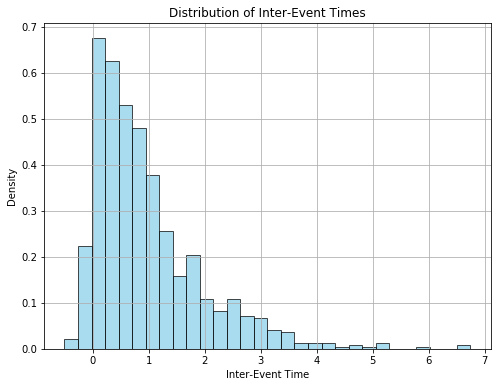

In [18]:
plot_inter_event_times(data_with_noise)

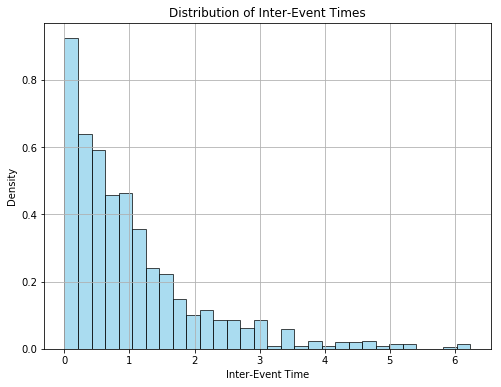

In [134]:
plot_inter_event_times(exponential_data)

In [19]:
is_exponential_distribution1(inter_event_times, 0.05)
is_exponential_distribution2(inter_event_times, 0.05)

True
False


In [127]:
is_exponential_distribution1(weibull_data, 0.05)
is_exponential_distribution2(weibull_data, 0.05)

True
False


In [133]:
is_exponential_distribution1(exponential_data, 0.05)
is_exponential_distribution2(exponential_data, 0.05)

True
True


In [97]:
is_exponential_distribution1(exponential_data, 0.05)
is_exponential_distribution2(exponential_data, 0.05)

True
True
